In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("dataset.csv")

print(df.columns)

Index(['Unnamed: 0', 'date', 'lon_rounded_up', 'lat_rounded_up', 'o2', 'chl',
       'no3', 'po4', 'si', 'salinity',
       ...
       'salinity_lead_29', 'temp_lead_29', 'o2_lead_29', 'chl_lead_30',
       'no3_lead_30', 'po4_lead_30', 'si_lead_30', 'salinity_lead_30',
       'temp_lead_30', 'o2_lead_30'],
      dtype='object', length=642)


In [3]:
df= pd.DataFrame(df, columns=['date', 'lon_rounded_up', 'lat_rounded_up', 'o2'])

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

# Function to create sequences for multi-step prediction
def create_sequences(data, sequence_length, prediction_steps):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length - prediction_steps + 1):
        sequences.append(data[i:i + sequence_length].values)
        # The target is now the next 'prediction_steps' values
        targets.append(data.iloc[i + sequence_length:i + sequence_length + prediction_steps]['o2'].values)
    return np.array(sequences), np.array(targets)


# Assume your dataframe is named 'df' and contains the columns ['date', 'lon_rounded_up', 'lat_rounded_up', 'o2']

# List to hold all sequences and targets
all_sequences = []
all_targets = []
all_lat_lon = []


# Normalize the entire dataframe first
df_normalized = df.copy()
df_normalized[['o2']] = (
    df[['o2']] - 
    df[['o2']].mean()) / \
    df[['o2']].std()

# Loop over each grid point and create sequences
unique_lats = df['lat_rounded_up'].unique()
unique_lons = df['lon_rounded_up'].unique()

# Creating sequences with a sequence length of 7 and predicting the next 10 days
sequence_length = 7
prediction_steps = 10

# Modify the loop to include the new `prediction_steps` argument
for lat in unique_lats:
    for lon in unique_lons:
        df_grid_point = df_normalized[(df_normalized['lat_rounded_up'] == lat) & (df_normalized['lon_rounded_up'] == lon)]
        df_grid_point = df_grid_point.sort_values('date')

        # Create sequences and targets with 10-day future prediction
        X, y = create_sequences(df_grid_point, sequence_length, prediction_steps)
        
        if X.shape[0] > 0:
            all_sequences.append(X)
            all_targets.append(y)
            all_lat_lon.extend([(lat, lon)] * len(X))


# Combine all sequences and targets into arrays
if all_sequences:  # Check if there are any valid sequences
    all_sequences = np.concatenate(all_sequences, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    all_lat_lon = np.array(all_lat_lon)
else:
    raise ValueError("No valid sequences were found. Check your data or sequence length.")

# First, create a train/val/test split for each grid point to ensure each lat/lon contributes to all splits
train_indices = []
val_indices = []
test_indices = []

for lat in unique_lats:
    for lon in unique_lons:
        # Get the indices corresponding to this grid point
        grid_indices = np.where((all_lat_lon[:, 0] == lat) & (all_lat_lon[:, 1] == lon))[0]
        
        # Skip if there are not enough samples to split
        if len(grid_indices) < 3:  # Minimum 3 for a train/val/test split
            print(f"Skipping grid point ({lat}, {lon}) due to insufficient data")
            continue
        
        # Split these indices into train, val, and test
        train_idx, temp_idx = train_test_split(grid_indices, test_size=0.3, random_state=42)
        val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)
        
        # Collect the indices
        train_indices.extend(train_idx)
        val_indices.extend(val_idx)
        test_indices.extend(test_idx)

# Now index into the sequences and targets to create the final splits
X_train, y_train = all_sequences[train_indices], all_targets[train_indices]
X_val, y_val = all_sequences[val_indices], all_targets[val_indices]
X_test, y_test = all_sequences[test_indices], all_targets[test_indices]

# Check the sizes of your splits
print(f'Training size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}')


Skipping grid point (-10, -70) due to insufficient data
Skipping grid point (-10, -65) due to insufficient data
Skipping grid point (-10, -60) due to insufficient data
Skipping grid point (-10, -55) due to insufficient data
Skipping grid point (-10, -50) due to insufficient data
Skipping grid point (-10, -45) due to insufficient data
Skipping grid point (-10, -40) due to insufficient data
Skipping grid point (-5, -70) due to insufficient data
Skipping grid point (-5, -65) due to insufficient data
Skipping grid point (-5, -60) due to insufficient data
Skipping grid point (-5, -55) due to insufficient data
Skipping grid point (-5, -50) due to insufficient data
Skipping grid point (-5, -45) due to insufficient data
Skipping grid point (-5, -40) due to insufficient data
Skipping grid point (0, -75) due to insufficient data
Skipping grid point (0, -70) due to insufficient data
Skipping grid point (0, -65) due to insufficient data
Skipping grid point (0, -60) due to insufficient data
Skippin

In [5]:
# Assuming 'date' is in the first column (adjust if it's not)
X_train = np.delete(X_train, 0, axis=-1)  # Remove the first column (date)
X_test = np.delete(X_test, 0, axis=-1)    # Do the same for X_test and X_val
X_val = np.delete(X_val, 0, axis=-1) 

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch import save, load

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout)
        
        self.fc = nn.Linear(hidden_size, hidden_size // 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(hidden_size // 2, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.relu(out)
        out = self.dropout(out)
        out = self.output_layer(out)
        return out

# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 64
num_layers = 2
output_size = 10  # Predicting 10 future values
dropout_rate = 0.2
learning_rate = 0.001
batch_size = 64
num_epochs = 100

# Initialize the LSTM model
model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout_rate)


In [9]:
# Convert numpy arrays to float32
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)


In [10]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler
# Patience = 5 meaning model wait for 5 epochs to see if the loss drop
# factor = 0.5 meaning the learning rate will be halved when the scheduler triggers
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Create DataLoader
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    
    scheduler.step(avg_loss)

# Save the model
torch.save(model.state_dict(), 'lstm_model.pth')

Epoch [1/100], Loss: 0.1250
Epoch [2/100], Loss: 0.0547
Epoch [3/100], Loss: 0.0482
Epoch [4/100], Loss: 0.0452
Epoch [5/100], Loss: 0.0439
Epoch [6/100], Loss: 0.0429
Epoch [7/100], Loss: 0.0419
Epoch [8/100], Loss: 0.0411
Epoch [9/100], Loss: 0.0410
Epoch [10/100], Loss: 0.0401
Epoch [11/100], Loss: 0.0400
Epoch [12/100], Loss: 0.0398
Epoch [13/100], Loss: 0.0398
Epoch [14/100], Loss: 0.0386
Epoch [15/100], Loss: 0.0386
Epoch [16/100], Loss: 0.0383
Epoch [17/100], Loss: 0.0384
Epoch [18/100], Loss: 0.0385
Epoch [19/100], Loss: 0.0382
Epoch [20/100], Loss: 0.0373
Epoch [21/100], Loss: 0.0378
Epoch [22/100], Loss: 0.0374
Epoch [23/100], Loss: 0.0377
Epoch [24/100], Loss: 0.0372
Epoch [25/100], Loss: 0.0371
Epoch [26/100], Loss: 0.0364
Epoch [27/100], Loss: 0.0366
Epoch [28/100], Loss: 0.0366
Epoch [29/100], Loss: 0.0371
Epoch [30/100], Loss: 0.0361
Epoch [31/100], Loss: 0.0363
Epoch [32/100], Loss: 0.0362
Epoch [33/100], Loss: 0.0360
Epoch [34/100], Loss: 0.0367
Epoch [35/100], Loss: 0

In [ ]:
#Recalling the lstm_model once it is trained.
if __name__ =="__main__":
    with open('lstm_model.pth','rb') as f:
        model.load_state_dict(load(f))

In [11]:
# Convert numpy arrays to float32
X_val = X_val.astype(np.float32)
y_val = y_val.astype(np.float32)

# Convert numpy arrays to PyTorch tensors
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)



In [ ]:
# Convert numpy arrays to float32
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

# Convert numpy arrays to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

Validation Loss: 0.0192
Test Loss: 0.0172


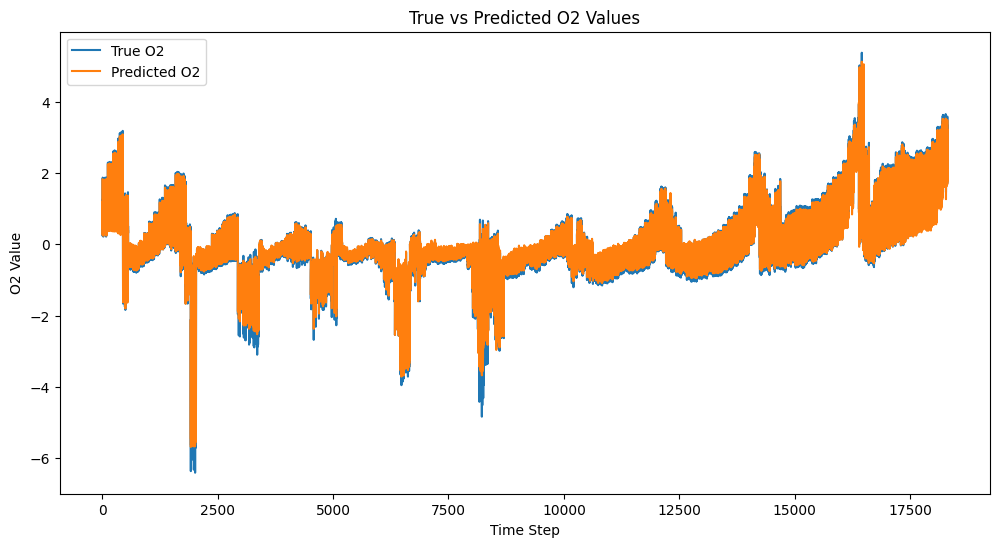

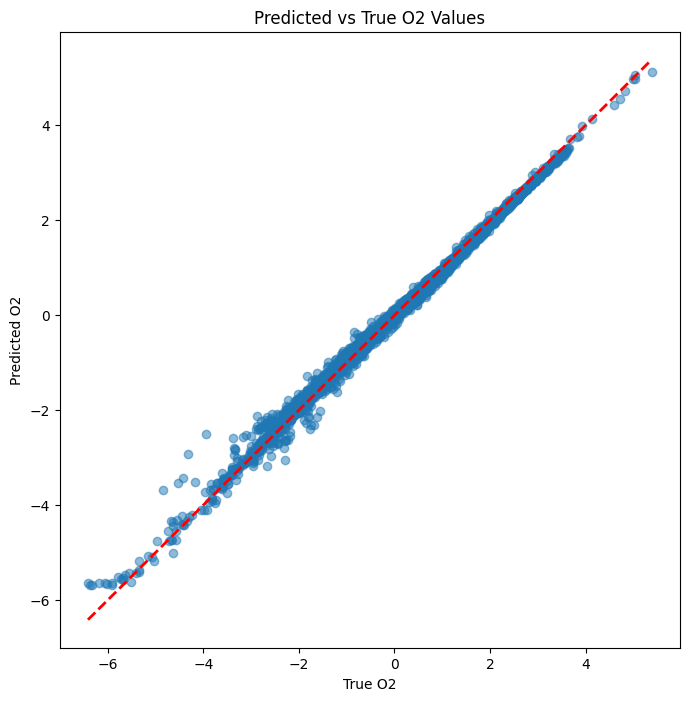

In [17]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    return avg_loss, np.array(all_predictions), np.array(all_targets)

# Create DataLoaders for validation and test sets
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate on validation set
val_loss, val_predictions, val_targets = evaluate_model(model, val_loader, criterion)
print(f"Validation Loss: {val_loss:.4f}")

# Evaluate on test set
test_loss, test_predictions, test_targets = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")

# Plotting predicted vs true O2 values
plt.figure(figsize=(12, 6))
plt.plot(test_targets[:, 0], label='True O2')  # Assuming the first column is O2
plt.plot(test_predictions[:, 0], label='Predicted O2')
plt.title('True vs Predicted O2 Values')
plt.xlabel('Time Step')
plt.ylabel('O2 Value')
plt.legend()
plt.show()

# Scatter plot of predicted vs true O2 values
plt.figure(figsize=(8, 8))
plt.scatter(test_targets[:, 0], test_predictions[:, 0], alpha=0.5)
plt.plot([min(test_targets[:, 0]), max(test_targets[:, 0])], 
         [min(test_targets[:, 0]), max(test_targets[:, 0])], 
         'r--', lw=2)
plt.title('Predicted vs True O2 Values')
plt.xlabel('True O2')
plt.ylabel('Predicted O2')
plt.show()